<b style="font-size:30px; line-height:1.2"><center>А/B-тестирование</b></center>

**Основная задача:** провести оценку результатов A/B-теста.

Имеются датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Этапы достижения основной задачи:
 - оценить корректность проведения теста;
 - проанализировать результаты теста;

Чтобы оценить корректность проведения теста, необходимо проверить:
 - пересечение тестовой аудитории с конкурирующим тестом; 
 - совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

# Шаг №1.  Загрузить данные и изучить их

<b style="font-size:18px; line-height:1.2"><center>Структура данных</b></center>


**ab_project_marketing_events.csv** — календарь маркетинговых событий на 2020 год:
 - `name` — название маркетингового события;
 - `regions` — регионы, в которых будет проводиться рекламная кампания;
 - `start_dt` — дата начала кампании;
 - `finish_dt` — дата завершения кампании.
 
 
 
**final_ab_new_users.csv** — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:
 - `user_id` — идентификатор пользователя;
 - `first_date` — дата регистрации;
 - `region` — регион пользователя;
 - `device` — устройство, с которого происходила регистрация.
 
 
**final_ab_events.csv** — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:
 - `user_id` — идентификатор пользователя;
 - `event_dt` — дата и время события;
 - `event_name` — тип события;
 - `details` — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.
 
 
**final_ab_participants.csv** — таблица участников тестов:
 - `user_id` — идентификатор пользователя;
 - `ab_test` — название теста;
 - `group` — группа пользователя.

In [1]:
pip install plotly==5.1.0

Импортируем необходимые библиотеки:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
colors =["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]
sns.set_palette(sns.color_palette(colors))

Оценив данные, создадим пайплайн для загрузки полного датасета `ab_project_marketing_events`, `final_ab_new_users`, `final_ab_events` и `final_ab_events`. Таким способом мы сразу преобразуем временные данные в необхимый тип, а также столбцы с категориальными данными преобразуем в категориальный тип. Следствием наших действий уменьшится занимаемая память DF. 

In [3]:
ab_project_marketing_events = pd.read_csv('ab_project_marketing_events.csv', header=0,
    parse_dates=['start_dt', 'finish_dt'])

final_ab_new_users = pd.read_csv('final_ab_new_users.csv', header=0,
    parse_dates=['first_date'],
    dtype={'device': 'category'})

final_ab_events = pd.read_csv('final_ab_events.csv', header=0,
    parse_dates=['event_dt'],
    dtype={'event_name': 'category'})

final_ab_participants = pd.read_csv('final_ab_participants.csv', header=0,
    dtype={'group': 'category', 'ab_test': 'category'})

Проверим DF на дубликаты. При наличии мы можем их удалить:

In [4]:
print('Количество дубликатов в ab_project_marketing_events:', ab_project_marketing_events.duplicated().sum())
print('Количество дубликатов в final_ab_new_users:', final_ab_new_users.duplicated().sum())
print('Количество дубликатов в final_ab_events:', final_ab_events.duplicated().sum())
print('Количество дубликатов в final_ab_participants:', final_ab_participants.duplicated().sum())

Количество дубликатов в ab_project_marketing_events: 0
Количество дубликатов в final_ab_new_users: 0
Количество дубликатов в final_ab_events: 0
Количество дубликатов в final_ab_participants: 0


Используя код из ранее сделанных проектов, сведем информацию о всех DF в одну сводную таблицу:

In [5]:
# Создадим словарь соответствия фрейма и его имени
dict_frames ={
    'ab_project_marketing_events': ab_project_marketing_events,
    'final_ab_new_users': final_ab_new_users,
    'final_ab_events': final_ab_events,
    'final_ab_participants': final_ab_participants
}

# Функция, для сбора информации о всех DF
def info_frame(dict_of_frames):
    def table(dataframe, name):
        # Собираем данные из конкретной таблицы
        columns = dataframe.columns
        count_of_rows = len(columns)
        total = dataframe.shape[0]
        
        part_total_table = pd.DataFrame(data =[[0] * 5] * count_of_rows, 
                                        columns = ['total',
                                                   'frame',
                                                   "columns",
                                                   "null_values, %",
                                                   "type"])
    
        part_total_table['total'] = [total] * count_of_rows
        part_total_table['frame'] = [name] * count_of_rows
        part_total_table['columns'] = columns
        
        
        for column in columns:
            curent_type = str(dataframe[column].dtype)
            count_of_null = dataframe[column].isnull().sum() * 100 / part_total_table['total']
            part_total_table.loc[part_total_table['columns'] == column,'null_values, %'] = count_of_null.round(2)
            part_total_table.loc[part_total_table['columns'] == column,'type'] = curent_type
        
        return part_total_table
    
    # объединяем даные из каждой таблицы в одну   
    final_frame = pd.DataFrame(columns = ['total','frame',"columns","null_values, %","type"])
    
    for name,frame in dict_of_frames.items():
        part_of_table = table(frame,name)
        final_frame = final_frame.append(part_of_table)
        
    final_frame = final_frame.reset_index(drop = True)
    final_frame_grouped = final_frame.groupby(['total','frame',"columns"]).first()
    final_frame_grouped = final_frame_grouped.style.background_gradient(cmap='Blues',subset=['null_values, %'])
    
    return final_frame_grouped
#Запуск функции
info_frame(dict_frames)

**Вывод:** В DF *final_ab_events* в столбце `details` 85.75% пустых значений, т.е. это та доля событий, которые не имеют дополнительных данных.

# Шаг 2. Исследовательский анализ данных

## 2.1. Исследование конверсии в воронке на разных этапах

Объединим DF по пользователям:

In [6]:
total_id = final_ab_new_users.merge(final_ab_events, on='user_id')
total_ab = total_id.merge(final_ab_participants, on='user_id', how='right')

Сделаем срез по тесту, указанный в ТЗ - `recommender_system_test:`

In [7]:
total_ab = total_ab.query('ab_test == "recommender_system_test"')

Посчитаем количество уникальных пользователей в каждой группе в каждом событии:

In [8]:
event_name_dict = total_ab[total_ab['event_name'].isna() == False]['event_name'].unique()
groups = total_ab['group'].unique()
simple_funnel = pd.DataFrame(columns=groups, index=event_name_dict)
for group in simple_funnel:
    for event in simple_funnel.index:
        simple_funnel.loc[event, group] = \
        total_ab[(total_ab['group'] == group) & (total_ab['event_name'] == event)]['user_id'].nunique()
simple_funnel = simple_funnel.reindex(['login', 'product_page', 'product_cart', 'purchase'])
simple_funnel

,A,B
login,2747,928
product_page,1780,523
product_cart,824,255
purchase,872,256


Построим воронку событий:

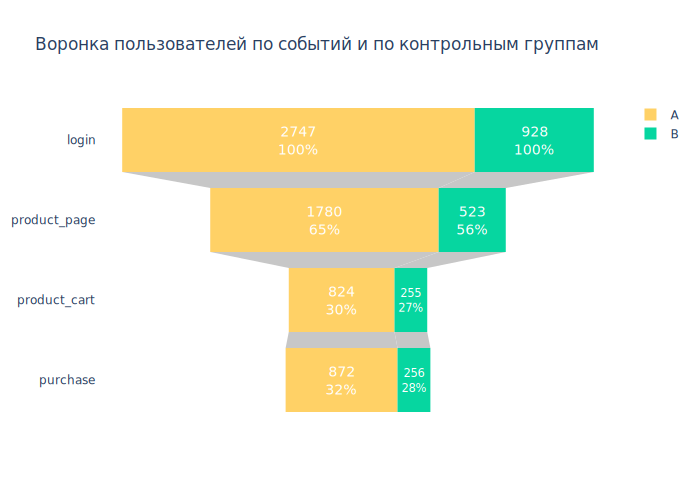

In [9]:
fig = go.Figure()
for i, group in enumerate(['A', 'B']):
    fig.add_trace(go.Funnel(
        name = str(group),
        y = simple_funnel.index,
        x = simple_funnel[group],
        textposition = "inside",
        textinfo = "value+percent initial",
        connector = {"fillcolor": '#c7c7c7'},
        hoverinfo = 'y',
        marker = {"color": colors[i+1]},
        insidetextfont = {'color': 'white', 'size': 14}))
fig.update_layout(title=dict(text='Воронка пользователей по событий и по контрольным группам'),
                  plot_bgcolor='#ffffff')
fig.show('svg')

**Вывод:** Воронка событий по пользователям в каждой контрольной группе показывает, что одинаковая доля пользователей 28-32% доходит до оплаты товара. Пользователи, перешедшие в корзину с товаром, также произвели оплату товаров. Конверсия события Оплата выше, чем событие Корзина, потому что есть пользователи, которые совершили покупку в один клик.

## 2.2. Количество событий на пользователя в каждой выборке

Определим количество событий на пользователей в каждом событии в каждой контрольной группе:

In [10]:
cnt_event = total_ab.groupby(['group', 'user_id'], as_index=False)['event_name'].count()

Определим среднее и медианное значение количества событий на пользователя в каждой выборке:

In [11]:
pivot_cnt_event = cnt_event.pivot_table(index='group', values='event_name', aggfunc=['mean','median'])
pivot_cnt_event.columns = pivot_cnt_event.columns.droplevel(1)
pivot_cnt_event.reset_index(inplace=True)
pivot_cnt_event.set_index('group', inplace=True)
pivot_cnt_event.index.name = None
pivot_cnt_event['mean'] = round(pivot_cnt_event['mean'], 1) 
pivot_cnt_event

,mean,median
A,5.0,4.0
B,1.9,0.0


**Вывод:** Среднее значение количества событий на пользователя составляет `А` = 5 , `B` = 1.9.

## 2.3. Распределение числа событий по дням

Создадим столбец с датой дня:

In [12]:
total_ab['day'] = total_ab['first_date'].dt.day

Определим количество событий в каждой контрольной группе по дням:

In [13]:
cnt_day = total_ab.groupby(['group','day'], as_index=False).agg({'event_name':'count'})

Определим среднее и медианное значение количества событий в каждой выборке по дням:

In [14]:
pivot_cnt_day = cnt_day.pivot_table(index='group', values='event_name', aggfunc=['mean','median'])
pivot_cnt_day.columns = pivot_cnt_day.columns.droplevel(1)
pivot_cnt_day.reset_index(inplace=True)
pivot_cnt_day.set_index('group', inplace=True)
pivot_cnt_day.index.name = None
pivot_cnt_day['mean'] = round(pivot_cnt_day['mean'], 1) 
pivot_cnt_day

,mean,median
A,1286.9,1245
B,359.6,258


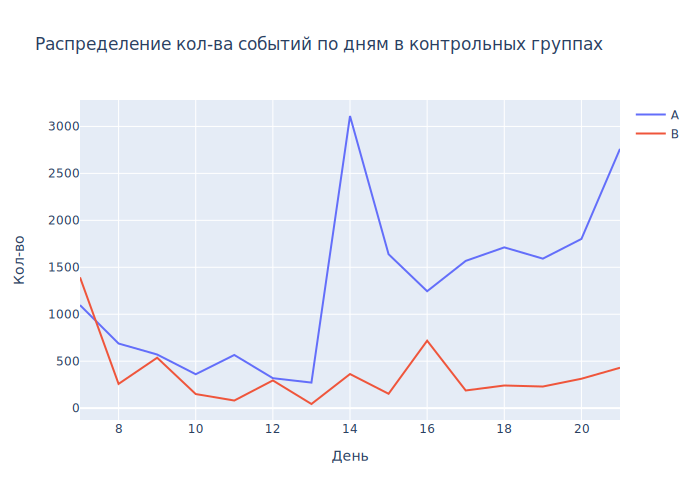

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=cnt_day['day'], y=cnt_day[cnt_day['group']=='A']['event_name'],
                    mode='lines',
                    name='A'))

fig.add_trace(go.Scatter(x=cnt_day['day'], y=cnt_day[cnt_day['group']=='B']['event_name'],
                    mode='lines',
                    name='B'))
fig.update_layout(title='Распределение кол-ва событий по дням в контрольных группах',
                   xaxis_title='День',
                   yaxis_title='Кол-во')
fig.show('svg')

**Вывод:** Медианное значение количества событий в день в контрольной группе `А`, ровняется 1245, а в `В` 258.

## 2.4. Дополнительные условия проведения теста

In [16]:
test_1 = total_ab
total_user = test_1['user_id'].nunique()
print('Количество пользователей в тесте = {:.0f}'.format(total_user))

Количество пользователей в тесте = 6701


Определим количество пользователей, находящихся в обеих контрольных группах: 

In [17]:
copy = lambda a,b: 'Количество пользователей, находящихся в обеих тестовых аудиториях = {}'\
.format(len(set(a) & set(b))) if len(set(a) & set(b)) else 'Совпадений нет'

user_A = test_1[test_1['group'] == 'A']['user_id']
user_B = test_1[test_1['group'] == 'B']['user_id']
print(copy(user_A, user_B))

Совпадений нет


Определим количество пользователей в каждом регионе

In [18]:
total_users = final_ab_new_users.groupby(
    'region', as_index=False).agg({'user_id':'nunique'})
total_users.rename(columns={'user_id':'total_user'}, inplace=True)

Определим количество пользоватлей в тесте и долю новых пользователей:

In [19]:
info_region = test_1.groupby('region', as_index=False).agg({'user_id':'nunique'})
info_region.rename(columns={'user_id':'n_user'}, inplace=True)
info_region = info_region.merge(total_users, on='region')
info_region['part, %'] = round(((info_region['n_user'] / info_region['total_user'].sum())*100), 2)
info_region

,region,n_user,total_user,"part, %"
0,APAC,45,3153,0.07
1,CIS,30,3155,0.05
2,EU,3481,46270,5.64
3,N.America,119,9155,0.19


Проверим насколько получаемая разница долей статистически значима:

In [20]:
def ztest(one, two):
    alpha = 0.05
    stat, p_value = proportions_ztest(one,two, value=0.15)
    print('p-значение: {:.10f}'.format(p_value))
    if p_value >= alpha:
        print(f'Разница долей статистически не значима')
    else:
        print(f'Разница долей статистически значима')
    print()
one = info_region[info_region['region'] == 'EU']['n_user'].values[0]
two = info_region[info_region['region'] == 'EU']['total_user'].values[0]
ztest(one,two)

p-значение: 0.0000000000
Разница долей статистически значима



In [21]:
test_1.query('"2020-12-21"<= first_date >= "2020-12-07"')['first_date'].unique()

array(['2020-12-21T00:00:00.000000000'], dtype='datetime64[ns]')

Проверим количество пользователей в каждой группе:

In [22]:
group_user = test_1.groupby('group', as_index=False).agg({'user_id':'nunique'})
group_user.rename(columns={'user_id':'n_user'}, inplace = True)
group_user.set_index('group', inplace=True)
group_user.index.name = None
group_user['part, %'] = round(((group_user['n_user'] / total_user)*100), 1)
group_user

,n_user,"part, %"
A,3824,57.1
B,2877,42.9


Выведим список маркетинговых событий:

In [23]:
ab_project_marketing_events.head(3)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19


Мы видим, что AB-тест выпал на перид Рождественской и Новогодней акций

Определим количество пользователей, находящихся в конкурирующих тестах:

In [24]:
task = total_id.merge(final_ab_participants, on='user_id', how='right')
test_1_user = task[task['ab_test'] == 'recommender_system_test']['user_id']
test_2_user = task[task['ab_test'] == 'interface_eu_test']['user_id']
print(copy(test_1_user, test_2_user))

Количество пользователей, находящихся в обеих тестовых аудиториях = 1602


**Вывод:** По предварительному анализу EDA можно сказать, что в тесте 6701 пользователей, что на 12% выше условий ТЗ (6000 пользователей). 

Также, доля пользователей из европейского региона составляет 5%, что намного ниже требований ТЗ (15%).

1602 пользователя учавствуют в двух конкурирующих тестах (что составляет 20% от общей аудитории исследуемого теста)

# Шаг 3. Проверка статистической разницы долей z-критерием

**Нулевая гипотеза:** доли конверсии между группами А и Б равны <br>
**Альтернативная гипотеза:** доли конверсии между группами А и Б равны различается

In [25]:
def check_z(data, alpha):
    """Функция для проверки гипотез  с помощью z_test
    Принимаемые аргументы data - датасет, events - события конверсий, alpha - уровень стат значимости.
    Функция считает конверсию от общего числа пользователей к тем кто совершил событие из events.
    Возвращает результат проверки гипотезы в виде строки.
    """
    #Определим список событий:
    events = list(data['event_name'].dropna().unique())
    
    #Посчитаем общее количество пользователей в группе
    count = data.groupby('group', as_index=False).agg({'user_id':'nunique'})
    count.columns = ['group', 'total_users']
    
    #Цикл по всем событиям
    for event in events:
        #Посчитаем количество пользователей в каждой группе на каждом событии:
        nobs = data[(data['event_name'] == event) & (data['group'].isin(count['group']))] \
        .groupby('group', as_index=False).agg({'user_id':'nunique'})
        nobs.columns = ['group', event]
        
        #Смержим таблицы
        pivot_z = pd.merge(count, nobs, on = 'group')
        
        #Используем Z-критерий
        stat, p_value = proportions_ztest(pivot_z[event].values,pivot_z['total_users'].values)
        print('{}: p-значение: {:.10f}'.format(event.upper(), p_value))
        if p_value >= alpha:
            print(f'Нулевая гипотеза НЕ ОТВЕРГАЕТСЯ: между группами нет различий конверсии по событию {event}')
        else:
            print(f'Нулевая гипотеза ОТВЕРГАЕТСЯ: между группами есть различия конверсии по событию {event}')
        print()
    
    #Отобразим воронку
    table = data.groupby(['group','event_name'], as_index=False).agg({'user_id':'nunique'})
    fig = go.Figure()
    for i in list(table['group'].unique()):
        df = table[table['group'] == i].sort_values('user_id', ascending=False).reset_index(drop=True)
        d = {2: 3, 3: 2}
        df = df.rename(d).sort_index()
        fig.add_trace(go.Funnel(
            name = i,
            y = df['event_name'],
            x = df['user_id'],
            textposition = "inside",
            textinfo = "value+percent initial",
            connector = {"fillcolor": '#c7c7c7'},
            hoverinfo = 'y',
            insidetextfont = {'color': 'white', 'size': 14}))
        fig.update_layout(title=dict(text='Воронка пользователей по событий и по контрольным группам'),
                          plot_bgcolor='#ffffff')
    fig.show('svg')

PURCHASE: p-значение: 0.0000000000
Нулевая гипотеза ОТВЕРГАЕТСЯ: между группами есть различия конверсии по событию purchase

PRODUCT_CART: p-значение: 0.0000000000
Нулевая гипотеза ОТВЕРГАЕТСЯ: между группами есть различия конверсии по событию product_cart

PRODUCT_PAGE: p-значение: 0.0000000000
Нулевая гипотеза ОТВЕРГАЕТСЯ: между группами есть различия конверсии по событию product_page

LOGIN: p-значение: 0.0000000000
Нулевая гипотеза ОТВЕРГАЕТСЯ: между группами есть различия конверсии по событию login



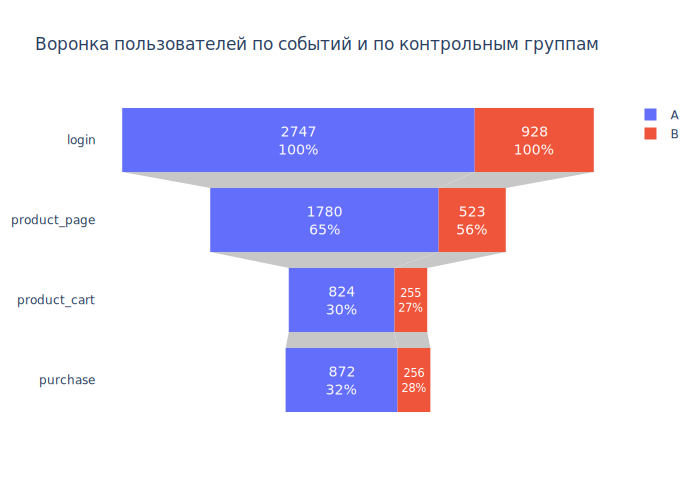

In [26]:
check_z(test_1, 0.05)

**Вывод:** По всем событиям доли конверсий в группах отличаются.

# Вывод

По предварительному анализу EDA можно сказать:
 - В тесте учавствуют 6701 пользователей, что на 12% выше условий ТЗ (6000 пользователей).
 - Доля пользователей из европейского региона составляет 5%, что намного ниже требований ТЗ (15%). Также, такая высока доля является статистически значимой в данной выборке.
 - 1602 пользователя учавствуют в двух конкурирующих тестах (что составляет 20% от общей аудитории исследуемого теста). Может быть влияние конкурирующего теста на результаты исследуемого теста.  
 - По всем событиям доли конверсий в группах статистически отличаются.
 - AB-тест выпал на перид Рождественской и Новогодней акций. 

**Рекомендация:** Разделить пользователей согласно условию и провести тест заново. Также стоит отметить, что тест проводился в предверии Нового года, следствием чего, показали (например, конверсия) явно будут имеь отличительный характер. 